# Spoiler Generator V2 (Question-Answering Score)

The Spoiler Generator is actually an Extractive Question Answering (QA) task of the pipeline.

The Concept is to treat the Headline as a Question and the Article as the Context. The model tries to find the exact span of text in the article that "answers" the headline.

Why it kills Clickbait: Clickbait headlines force us to click to find one specific piece of information. This tool can extract that answer and show it immediately, hence "solved" the clickbait.

This use different base/pretrained model compared to Spoiler Generator V1

## Install and Setup

In [ ]:
!pip install transformers pandas peft torch accelerate bitsandbytes

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import warnings
import os
import zipfile

warnings.filterwarnings("ignore")
print("Libraries installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 9.5 MB/s eta 0:00:00
Libraries installed.


## Model Class

In [ ]:
class SpoilerGenV2:
    def __init__(self, base_model_id, adapter_path):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"1. Loading Base Model: {base_model_id}...")

        # Load Base Model
        self.base_model = AutoModelForCausalLM.from_pretrained(
            base_model_id,
            torch_dtype=torch.float16,
            device_map="auto"
        )

        print(f"2. Loading Adapter from: {adapter_path}...")
        # Load Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(adapter_path)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Load Adapter
        self.model = PeftModel.from_pretrained(self.base_model, adapter_path)
        self.model.eval()
        print("SUCCESS: Spoiler Generator V2 Loaded!")

    def predict(self, headline, content):
        prompt = f"""### Instruction:
Jawablah pertanyaan apa benar (Judul) berdasarkan Konteks (Artikel).

### Konteks:
{content[:2000]}

### Judul:
{headline}

### Jawaban:
"""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

        try:
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=50,
                    temperature=0.1,
                    do_sample=False,
                    return_dict_in_generate=True,
                    output_scores=True
                )

            decoded = self.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

            if "Jawaban:" in decoded:
                answer_text = decoded.split("Jawaban:")[-1].strip()
            else:
                answer_text = decoded.strip()

            # Calculate Confidence (Perplexity-based)
            # Simple heuristic: Geometric mean of token probabilities
            transition_scores = self.model.compute_transition_scores(
                outputs.sequences, outputs.scores, normalize_logits=True
            )
            log_prob_sum = torch.sum(transition_scores)
            seq_len = transition_scores.shape[-1]
            confidence_score = torch.exp(log_prob_sum / seq_len).item()

            return answer_text, confidence_score

        except Exception as e:
            print(f"Error: {e}")
            return "", 0.0

# Load Model

In [ ]:
import os
import zipfile
import gdown

ZIP_ID = "1sso1pAxYM1faZ-45kEnraFq5sDj8E2bh"
ZIP_PATH = "/content/spoiler_generator.zip"
EXTRACT_PATH = "/content/spoiler_adapter_v2"
BASE_ID = "unsloth/Llama-3.2-1B-Instruct"

# Download the ZIP model
if not os.path.exists(ZIP_PATH):
    print(f"Downloading from Google Drive (id={ZIP_ID})...")
    gdown.download(id=ZIP_ID, output=ZIP_PATH, quiet=False)
else:
    print("ZIP already exists, skipping download.")

# Unzip the file
if not os.path.exists(EXTRACT_PATH):
    print(f"Extracting {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("✅ Extraction complete.")
    except zipfile.BadZipFile:
        print("❌ Error: The downloaded file is not a valid zip.")
else:
    print("Folder already exists. Skipping extraction.")

# Initialize the Model
print("Initializing Llama V2...")
if os.path.exists(EXTRACT_PATH):
    spoiler_generator_v2 = SpoilerGenV2(BASE_ID, EXTRACT_PATH)
    print("Model initialized as 'llama_v2'")
else:
    print("❌ Error: Adapter folder not found. Model not initialized.")

Downloading...
From (original): https://drive.google.com/uc?id=1sso1pAxYM1faZ-45kEnraFq5sDj8E2bh
From (redirected): https://drive.google.com/uc?id=1sso1pAxYM1faZ-45kEnraFq5sDj8E2bh&confirm=t&uuid=a8296df9-3619-468e-b30b-0d9ae554349d
To: /content/spoiler_generator.zip
100%|██████████| 169M/169M [00:05<00:00, 30.0MB/s]


Extracting /content/spoiler_generator.zip...
✅ Extraction complete.
Initializing Llama V2...
1. Loading Base Model: unsloth/Llama-3.2-1B-Instruct...


config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

2. Loading Adapter from: /content/spoiler_adapter_v2...
SUCCESS: Spoiler Generator V2 Loaded!
Model initialized as 'llama_v2'


In [ ]:
if os.path.exists(EXTRACT_PATH):
    print("\n--- SINGLE INFERENCE EXAMPLE ---")

    # Example Data
    test_headline = "Inilah Alasan Mengapa Harga Cabai Naik Drastis"
    test_content = "Harga cabai di pasar tradisional mengalami kenaikan drastis hingga 50% dalam sepekan terakhir. Menurut para pedagang, kenaikan ini disebabkan oleh gagal panen akibat cuaca ekstrem di berbagai daerah penghasil. Pasokan yang menipis membuat harga melonjak tajam."

    print(f"Headline: {test_headline}")
    print(f"Content Snippet: {test_content[:100]}...")

    # Run Prediction
    answer, confidence = spoiler_generator_v2.predict(test_headline, test_content)

    print("\n--- MODEL OUTPUT ---")
    print(f"Answer: {answer}")
    print(f"Confidence Score: {confidence:.4f}")

    if confidence < 0.4:
        print("Verdict: Low Confidence (Possible Clickbait / No Answer Found)")
    else:
        print("Verdict: High Confidence (Non-Clickbait)")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- SINGLE INFERENCE EXAMPLE ---
Headline: Inilah Alasan Mengapa Harga Cabai Naik Drastis
Content Snippet: Harga cabai di pasar tradisional mengalami kenaikan drastis hingga 50% dalam sepekan terakhir. Menur...

--- MODEL OUTPUT ---
Answer: Kenaikan ini disebabkan oleh gagal panen akibat cuaca ekstrem di berbagai daerah penghasil. Pasokan yang menipis membuat harga melonjak tajam.
Confidence Score: 0.9448
Verdict: High Confidence (News)


## Load Dataset

In [ ]:
file_id = '1VeaXUW5d34siLszKIDZ1xN1NWzLt2kT5'
download_url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(download_url)

display(df)

,title,content,label
0,Anak Penjaga Kebersihan Masjid Lantamal 1 Bela...,Setelah dihebohkan dengan kemunculan calon tar...,clickbait
1,Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan ...,Jelang akhir tahun kabar kenaikan tarif iuran...,non-clickbait
2,"Pendukung Jokowi Ngaku Diculik di Masjid, Ini ...",Pengurus Dewan Kemakmuran Masjid (DKM) Al-Fala...,clickbait
3,"Sebentar Lagi, Minyak Curah Dilarang, Warga Ha...",Menteri Perdagangan Enggartiasto Lukita melara...,clickbait
4,Ya Tuhan... Hubungan Sedarah di Sumut Meningka...,"Miris, meski dianggap tabu dalam agama maupun ...",clickbait
...,...,...,...
15235,"Tampil Perkasa, Timnas Indonesia U-16 Libas Ma...","–,melawan Kepulauan Mariana Utara dalam laga k...",clickbait
15236,Polda Kalsel Sudah Petakan Titik Api Kebakaran...,Polda Kalimantan Selatan atau Kalsel masih ter...,non-clickbait
15237,Wall Street Dibuka Melemah Imbas Laba FedEx Te...,Wall Street dibuka turun pada hari ini. Hal in...,non-clickbait
15238,"Diperiksa 4 Jam, Pelapor Pendiri Kaskus Diceca...",Titi Sumawijaya Empel yang melaporkan pendiri ...,clickbait


## Inference

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
from tqdm import tqdm

n = int(len(df) * 0.01)
df_sample = df.iloc[:n].copy()
print(f"Running Llama V2 Inference on {len(df_sample)} rows...")

spoiler_generator_v2_answers = []
spoiler_generator_v2_scores = []

for index, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    try:
        ans, score = spoiler_generator_v2.predict(row['title'], row['content'])

        if "tidak ada jawaban" in ans.lower() or "maaf" in ans.lower():
            score = 0.1

        spoiler_generator_v2_answers.append(ans)
        spoiler_generator_v2_scores.append(score)
    except Exception as e:
        print(f"Error at row {index}: {e}")
        spoiler_generator_v2_answers.append("")
        spoiler_generator_v2_scores.append(0.0)

# Save results to dataframe
df_sample['llama_answer'] = spoiler_generator_v2_answers
df_sample['llama_score'] = spoiler_generator_v2_scores


Running Llama V2 Inference on 152 rows...


100%|██████████| 152/152 [04:44<00:00,  1.87s/it]


In [ ]:
display(df_sample)

,title,content,label,llama_answer,llama_score
0,Anak Penjaga Kebersihan Masjid Lantamal 1 Bela...,Setelah dihebohkan dengan kemunculan calon tar...,clickbait,Karena ia dapat menghafal ayat Alquran dan mel...,0.867786
1,Wakil Menkeu : Kenaikan Iuran BPJS Tidak Akan ...,Jelang akhir tahun kabar kenaikan tarif iuran...,non-clickbait,Kenaikan tarif ini rencananya akan berlaku mul...,0.801283
2,"Pendukung Jokowi Ngaku Diculik di Masjid, Ini ...",Pengurus Dewan Kemakmuran Masjid (DKM) Al-Fala...,clickbait,Pengurus Dewan Kemakmuran Masjid (DKM) Al-Fala...,0.939177
3,"Sebentar Lagi, Minyak Curah Dilarang, Warga Ha...",Menteri Perdagangan Enggartiasto Lukita melara...,clickbait,Kebijakan ini tidak dilakukan dengan masa tran...,0.923019
4,Ya Tuhan... Hubungan Sedarah di Sumut Meningka...,"Miris, meski dianggap tabu dalam agama maupun ...",clickbait,"Kasus yang baru kami tangani, masalahnya adala...",0.957630
...,...,...,...,...,...
147,"Sudah Dikafani, Bangkit Lagi, Ternyata Pura-pu...",Warganet digegerkan oleh beredarnya video maya...,clickbait,"Maaf, informasi tersebut tidak ditemukan dalam...",0.100000
148,"Gagal Nyuri di Masjid, Dua Maling Motor Tewas ...",Maling memang tidak mengenal lokasi. Motor di ...,clickbait,Keduanya pun beraksi mencuri sepeda motor ters...,0.807723
149,"Suami Barusan Keluar Rumah, Istri Masukkan Sel...",Kelakuan Nur Aeni (25) memasukkan selingkuhann...,clickbait,Kemudian... Crottt...,0.558762
150,"Disuruh Kecilkan Volume Musik saat Magrib, Pri...","Siapa yang mengira, nyawa Rudi Canli (40) mela...",clickbait,Korban tewas ditusuk tombak oleh Poken (40). K...,0.861906


In [ ]:
print(df_sample['llama_score'].describe())

count    152.000000
mean       0.670539
std        0.319246
min        0.100000
25%        0.517904
50%        0.846075
75%        0.908479
max        0.976227
Name: llama_score, dtype: float64


## Evaluation

🔎 Overall AUC (threshold-independent): 0.5475

Threshold = 0.01
Accuracy  = 0.7368
Classification Report:
              precision    recall  f1-score   support

        News     0.0000    0.0000    0.0000        40
   Clickbait     0.7368    1.0000    0.8485       112

    accuracy                         0.7368       152
   macro avg     0.3684    0.5000    0.4242       152
weighted avg     0.5429    0.7368    0.6252       152

Threshold = 0.02
Accuracy  = 0.7368
Classification Report:
              precision    recall  f1-score   support

        News     0.0000    0.0000    0.0000        40
   Clickbait     0.7368    1.0000    0.8485       112

    accuracy                         0.7368       152
   macro avg     0.3684    0.5000    0.4242       152
weighted avg     0.5429    0.7368    0.6252       152

Threshold = 0.05
Accuracy  = 0.7303
Classification Report:
              precision    recall  f1-score   support

        News     0.4286    0.0750    0.1277        40
   Clickbait 

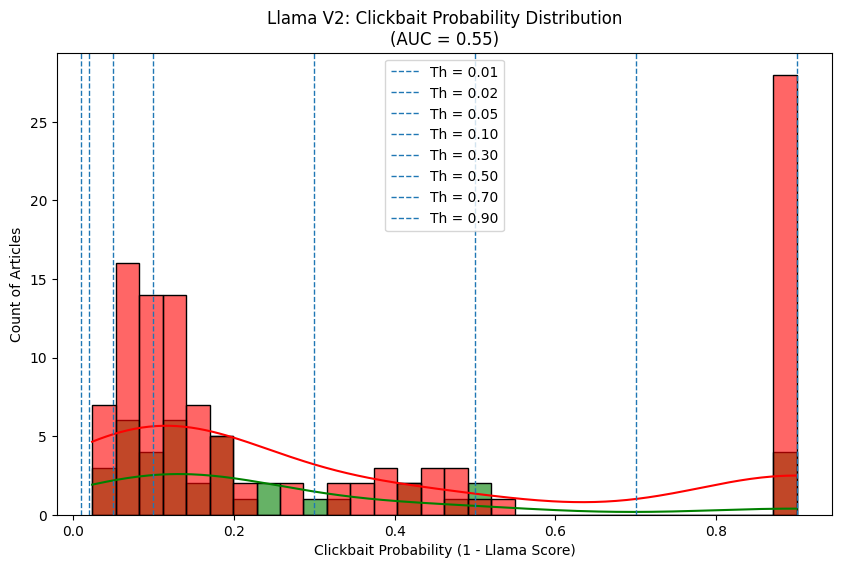


Saved results to 'final_dataset_with_llama_v2_sample.csv'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np

label_map = {'clickbait': 1, 'non-clickbait': 0}

try:
    # Prepare Ground Truth
    y_true = df_sample['label'].str.lower().map(label_map)
    valid_idx = y_true.dropna().index
    y_true = y_true.loc[valid_idx]

    # Prepare Model Probabilities
    #    y_prob = "clickbait probability"
    y_prob = 1.0 - np.array(df_sample.loc[valid_idx, 'llama_score'], dtype=float)

    # Sanity check: AUC (independent of threshold)
    auc = roc_auc_score(y_true, y_prob)
    print(f"🔎 Overall AUC (threshold-independent): {auc:.4f}\n")

    # Experiment with Thresholds
    thresholds = [0.01, 0.02, 0.05, 0.10, 0.30, 0.50, 0.70, 0.90]

    for thr in thresholds:
        y_pred = (y_prob > thr).astype(int)

        acc = accuracy_score(y_true, y_pred)
        print(f"======================")
        print(f"Threshold = {thr:.2f}")
        print(f"Accuracy  = {acc:.4f}")
        print("Classification Report:")
        print(classification_report(
            y_true,
            y_pred,
            target_names=['Non-Clickbait', 'Clickbait'],
            digits=4
        ))

    # Visualization
    plt.figure(figsize=(10, 6))

    sns.histplot(
        x=y_prob,
        hue=df_sample.loc[valid_idx, 'label'],
        kde=True,
        bins=30,
        palette={'clickbait': 'red', 'non-clickbait': 'green'},
        alpha=0.6
    )

    plt.title(f"Llama V2: Clickbait Probability Distribution\n(AUC = {auc:.2f})")
    plt.xlabel("Clickbait Probability (1 - Llama Score)")
    plt.ylabel("Count of Articles")

    for thr in thresholds:
        plt.axvline(thr, linestyle='--', linewidth=1, label=f'Th = {thr:.2f}')

    # Avoid duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    seen = set()
    uniq_handles, uniq_labels = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            uniq_handles.append(h)
            uniq_labels.append(l)
            seen.add(l)

    plt.legend(uniq_handles, uniq_labels)
    plt.show()

except Exception as e:
    print(f"\nCould not evaluate: {e}")
    print("Check if your 'label' column contains 'clickbait', or 'non-clickbait'.")

df_sample.to_csv("final_dataset_with_llama_v2_sample.csv", index=False)
print("\nSaved results to 'final_dataset_with_llama_v2_sample.csv'")
